In [148]:
# YIKAI MAO

# quantum fourier transform algorithm generator

In [149]:
# reproducibility
%env PYTHONHASHSEED=0

# Qiskit libraries
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, transpile, Aer
from qiskit.tools.jupyter import *
from qiskit.visualization import *
#from qiskit.transpiler.passes import RemoveBarriers
from qiskit.circuit.library import Diagonal, QFT, GroverOperator, ZGate
from qiskit.quantum_info import Statevector, random_statevector
from qiskit.extensions import Initialize

print('*'*104)
print("available simulators:")
display(Aer.backends())
print('*'*104)

# other libraries
from tqdm import tqdm #tqdm(iterable)
from random import sample, choice
import math
import numpy as np
from numpy import pi
import matplotlib.pyplot as plt
import matplotlib.transforms as trans
from sklearn.metrics import r2_score
import pickle

env: PYTHONHASHSEED=0
********************************************************************************************************
available simulators:


[AerSimulator('aer_simulator'),
 AerSimulator('aer_simulator_statevector'),
 AerSimulator('aer_simulator_density_matrix'),
 AerSimulator('aer_simulator_stabilizer'),
 AerSimulator('aer_simulator_matrix_product_state'),
 AerSimulator('aer_simulator_extended_stabilizer'),
 AerSimulator('aer_simulator_unitary'),
 AerSimulator('aer_simulator_superop'),
 QasmSimulator('qasm_simulator'),
 StatevectorSimulator('statevector_simulator'),
 UnitarySimulator('unitary_simulator'),
 PulseSimulator('pulse_simulator')]

********************************************************************************************************


In [150]:
# utility functions

def run_ideal_simulation(circuit, shots, optimization_level, seed, show_plot, show_counts):
    # assume perfect device with no noise
    # circuit = circuit to simulate, not transpiled
    # shots = how many shots to run
    # optimization_level = passed to the transpiler, min = 0, max = 3
    # seed = random seed for simultaion, can be None
    # show_counts = T/F, plot result or not

    simulator = Aer.get_backend('aer_simulator')
    temp_qc = transpile(circuit, simulator, optimization_level=optimization_level)
    job_temp = simulator.run(temp_qc, shots=shots, seed_simulator=seed)
    temp_results = job_temp.result()
    
    # build simulation result dict
    raw_counts = temp_results.get_counts()
    # print("raw counts:\n", raw_counts)
    num_clbits = circuit.num_clbits
    ideal_result_dict = {}

    # sorting the raw counts, add state zero
    for i in range(pow(2, num_clbits)):
        bin_str = format(i, str('0>' + str(num_clbits) + 'b'))
        if bin_str not in raw_counts:
            ideal_result_dict[bin_str] = 0
        else:
            ideal_result_dict[bin_str] = raw_counts[bin_str]

    if show_plot:
        plot = plot_histogram(raw_counts, title='ideal simulation')
        display(plot)
            
    if show_counts:
        print('sorted counts:')
        print(ideal_result_dict)
    
    return ideal_result_dict, raw_counts

def decomposer(circ, level=1):
    # decompose the circuit to see the basis gates
    # level = how many times to decompose
    
    decomposed_circ = circ
    
    for i in range(level):
        decomposed_circ = decomposed_circ.decompose()
        
    return decomposed_circ

# https://stackoverflow.com/questions/2566412/find-nearest-value-in-numpy-array
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return array[idx]

def random_bin_str(width, zero=False):
    # return random binary string based on width
    # zero = T/F, T = include 0, F = do not return 0
    # width cannot be 0
    
    if width == 0:
        return None
    
    b = np.random.randint(2, size=width)
    b_str = ''.join(map(str, b.tolist()))
    
    if zero==True:
        return b_str
    
    else:
        while '1' not in b_str:
            b = np.random.randint(2, size=width)
            b_str = ''.join(map(str, b.tolist()))
        
        return b_str

In [151]:
# https://github.com/Qiskit/textbook/blob/main/notebooks/ch-algorithms/quantum-fourier-transform.ipynb

def qft_rotations(circuit, n):
    
    if n == 0:
        return circuit
    n -= 1
    
    circuit.h(n)
    
    for qubit in range(n):
        circuit.cp(pi/2**(n-qubit), qubit, n)
        
    qft_rotations(circuit, n)

def swap_registers(circuit, n):
    
    for qubit in range(n//2):
        circuit.swap(qubit, n-qubit-1)
        
    return circuit

def initilize_in_fourier_basis(n, number):
    # NOTE: NO OUT OF BOUND CHECK!
    
    circuit = QuantumCircuit(n)
    
    if len(f"{number:b}") > n:
        print("number too big! not enough qubits!")
    
    for qubit in range(n):
        circuit.h(qubit)
        circuit.p(number*pi/(2**(n-qubit-1)), qubit)
        
    return circuit

def qft(n, options=[]):
    # n is problem size, NOT necessarily equal to the qubit count of the generated circuit
    # options = [initialize, inverse, measurement]
    # initialize = decimal number to be initialized in fourier basis, 0 = random, -1 = no initialization
    # inverse = T/F output inverse QFT
    # measurement = T/F add measurement

    initialize = options[0]
    inverse = options[1]
    measurement = options[2]
        
    qft_circuit = QuantumCircuit(n)
    
    qft_rotations(qft_circuit, n)
    swap_registers(qft_circuit, n)
    
    if inverse:
        qft_circuit = qft_circuit.inverse()
        
    if measurement:
        qft_circuit.measure_all()
        
    if initialize > 0:
        initialize_number = initialize
        initialize_circuit = initilize_in_fourier_basis(n, initialize_number)
        qft_circuit = initialize_circuit & qft_circuit
    elif initialize == 0:
        initialize_number = np.random.randint(2**n)
        initialize_circuit = initilize_in_fourier_basis(n, initialize_number)
        qft_circuit = initialize_circuit & qft_circuit
    # else:
        # do nothing
    
    return qft_circuit

In [152]:
# https://github.com/Qiskit/textbook/blob/main/notebooks/ch-algorithms/quantum-phase-estimation.ipynb

def qpe(n, options=[]):
    # n is problem size, NOT necessarily equal to the qubit count of the generated circuit
    # options = [phase_theta]
    # phase_theta = the decimal number to be initialized in fourier basis
    
    phase_theta = options[0]
    
    # n counting qubits
    # 1 eigenstate qubit
    qpe_circuit = QuantumCircuit(n+1, n)
    
    # Prepare the eigenstate |psi>:
    qpe_circuit.x(n)
    
    # Apply H-Gates to counting qubits:
    for qubit in range(n):
        qpe_circuit.h(qubit)
    
    # Do the controlled-U operations:
    phase_lambda = (2*pi)*(phase_theta) # divide the result by 2^n to get phase_theta
    repetitions = 1
    for counting_qubit in range(n):
        for i in range(repetitions):
            qpe_circuit.cp(phase_lambda, counting_qubit, n)
        repetitions *= 2
    
    # Do the inverse QFT:
    qpe_circuit = qpe_circuit & qft(n, [-1, True, True])
    
    return qpe_circuit

In [153]:
# https://github.com/Qiskit/textbook/blob/main/notebooks/ch-algorithms/shor.ipynb
# https://github.com/ttlion/ShorAlgQiskit

def egcd(a, b):
    if a == 0:
        return (b, 0, 1)
    else:
        g, y, x = egcd(b % a, a)
        return (g, x - (b // a) * y, y)

def modinv(a, m):
    g, x, y = egcd(a, m)
    if g != 1:
        raise Exception('modular inverse does not exist')
    else:
        return x % m

def get_value_a(N):
    # a and N are coprime
    a = 2
    a_list = []
    
    while a <= N:
        if math.gcd(a,N) == 1:
            a_list.append(a)
        a = a + 1
        
    return a_list
    
def getAngles(a,N):
    # calculates the array of angles to be used in the addition in Fourier Space
    s=bin(int(a))[2:].zfill(N) 
    angles=np.zeros([N])
    for i in range(0, N):
        for j in range(i,N):
            if s[j]=='1':
                angles[N-i-1]+=math.pow(2, -(j-i))
        angles[N-i-1]*=np.pi
    return angles

def ccphase(circuit,angle,ctl1,ctl2,tgt):
    # doubly controlled phase gate
    circuit.cu(0,0,angle/2,0,ctl1,tgt)
    circuit.cx(ctl2,ctl1)
    circuit.cu(0,0,-angle/2,0,ctl1,tgt)
    circuit.cx(ctl2,ctl1)
    circuit.cu(0,0,angle/2,0,ctl2,tgt)

def phiADD(circuit,q,a,N,inv):
    # performs addition by a in Fourier Space
    # Can also be used for subtraction by setting the parameter inv to a value different from 0
    angle=getAngles(a,N)
    for i in range(0,N):
        if inv==0:
            circuit.p(angle[i],q[i])
        else:
            circuit.p(-angle[i],q[i])

def cphiADD(circuit,q,ctl,a,n,inv):
    # Single controlled version of the phiADD circuit
    angle=getAngles(a,n)
    for i in range(0,n):
        if inv==0:
            circuit.cu(0,0,angle[i],0,ctl,q[i])
        else:
            circuit.cu(0,0,-angle[i],0,ctl,q[i])

def ccphiADD(circuit,q,ctl1,ctl2,a,n,inv):
    # Doubly controlled version of the phiADD circuit
    angle=getAngles(a,n)
    for i in range(0,n):
        if inv==0:
            ccphase(circuit,angle[i],ctl1,ctl2,q[i])
        else:
            ccphase(circuit,-angle[i],ctl1,ctl2,q[i])

def create_QFT(circuit,up_reg,n,with_swaps,inv):
    if inv==0:
        i=n-1
        # Apply the H gates and Cphases
        # The Cphases with |angle| < threshold are not created because they do 
        # nothing. The threshold is put as being 0 so all CPhases are created,
        # but the clause is there so if wanted just need to change the 0 of the
        # if-clause to the desired value
        while i>=0:
            circuit.h(up_reg[i])        
            j=i-1  
            while j>=0:
                if (np.pi)/(pow(2,(i-j))) > 0:
                    circuit.cu(0,0,(np.pi)/(pow(2,(i-j))),0 , up_reg[i] , up_reg[j] )
                    j=j-1   
            i=i-1  
    
        # If specified, apply the Swaps at the end
        if with_swaps==1:
            i=0
            while i < ((n-1)/2):
                circuit.swap(up_reg[i], up_reg[n-1-i])
                i=i+1
                
    if inv==1:
        # If specified, apply the Swaps at the beggining
        if with_swaps==1:
            i=0
            while i < ((n-1)/2):
                circuit.swap(up_reg[i], up_reg[n-1-i])
                i=i+1
        
        # Apply the H gates and Cphases
        # The Cphases with |angle| < threshold are not created because they do 
        # nothing. The threshold is put as being 0 so all CPhases are created,
        # but the clause is there so if wanted just need to change the 0 of the
        # if-clause to the desired value
        i=0
        while i<n:
            circuit.h(up_reg[i])
            if i != n-1:
                j=i+1
                y=i
                while y>=0:
                     if (np.pi)/(pow(2,(j-y))) > 0:
                        circuit.cu(0,0, - (np.pi)/(pow(2,(j-y))),0 , up_reg[j] , up_reg[y] )
                        y=y-1   
            i=i+1

def ccphiADDmodN(circuit, q, ctl1, ctl2, aux, a, N, n, inv):
    # doubly controlled modular addition by a
    if inv==0:
        ccphiADD(circuit, q, ctl1, ctl2, a, n, 0)
        phiADD(circuit, q, N, n, 1)
        create_QFT(circuit, q, n, 0, 1)
        circuit.cx(q[n-1],aux)
        create_QFT(circuit,q,n,0,0)
        cphiADD(circuit, q, aux, N, n, 0)
        
        ccphiADD(circuit, q, ctl1, ctl2, a, n, 1)
        create_QFT(circuit, q, n, 0, 1)
        circuit.x(q[n-1])
        circuit.cx(q[n-1], aux)
        circuit.x(q[n-1])
        create_QFT(circuit,q,n,0,0)
        ccphiADD(circuit, q, ctl1, ctl2, a, n, 0)
        
    if inv==1:
        ccphiADD(circuit, q, ctl1, ctl2, a, n, 1)
        create_QFT(circuit, q, n, 0, 1)
        circuit.x(q[n-1])
        circuit.cx(q[n-1],aux)
        circuit.x(q[n-1])
        create_QFT(circuit, q, n, 0, 0)
        ccphiADD(circuit, q, ctl1, ctl2, a, n, 0)
        
        cphiADD(circuit, q, aux, N, n, 1)
        create_QFT(circuit, q, n, 0, 1)
        circuit.cx(q[n-1], aux)
        create_QFT(circuit, q, n, 0, 0)
        phiADD(circuit, q, N, n, 0)
        ccphiADD(circuit, q, ctl1, ctl2, a, n, 1)

def cMULTmodN(circuit, ctl, q, aux, a, N, n):
    # single controlled modular multiplication by a
    create_QFT(circuit,aux,n+1,0,0)
    for i in range(0, n):
        ccphiADDmodN(circuit, aux, q[i], ctl, aux[n+1], (2**i)*a % N, N, n+1, 0)
    create_QFT(circuit, aux, n+1, 0, 1)

    for i in range(0, n):
        circuit.cswap(ctl,q[i],aux[i])

    a_inv = modinv(a, N)
    create_QFT(circuit, aux, n+1, 0, 0)
    i = n-1
    while i >= 0:
        ccphiADDmodN(circuit, aux, q[i], ctl, aux[n+1], math.pow(2,i)*a_inv % N, N, n+1, 1)
        i -= 1
    create_QFT(circuit, aux, n+1, 0, 1)
    
def shor(N, options=[]):
    # N is problem size, NOT necessarily equal to the qubit count of the generated circuit
    # in Shor's algrithm, N is the number to be factored
    # options = [random]
    # random = T/F, use random a, if False, use the smallest a

    random = options[0]
    
    a_list = get_value_a(N)
    if random:
        a = choice(a_list)
    else:
        a = a_list[0]
    # print('a =', a)
        
    n = math.ceil(math.log(N,2))
    # print('Total number of qubits used: {0}\n'.format(4*n+2))
    
    aux = QuantumRegister(n+2, 'aux')
    up_reg = QuantumRegister(2*n, 'counting')
    down_reg = QuantumRegister(n, 'mod_mult')
    up_classic = ClassicalRegister(2*n, 'c')

    shor_circuit = QuantumCircuit(down_reg, up_reg, aux, up_classic)
    shor_circuit.h(up_reg)
    shor_circuit.x(down_reg[0])
    
    for i in range(0, 2*n):
        temp_circuit = QuantumCircuit(down_reg, up_reg, aux)
        cMULTmodN(temp_circuit, up_reg[i], down_reg, aux, int(pow(a, pow(2, i))), N, n)
        temp_circuit = temp_circuit.to_instruction(label='c_mod_mult')
        shor_circuit = shor_circuit & temp_circuit
        
    inv_qft_circuit = qft(2*n, [-1, True, False]).to_instruction(label='inv_qft')
    shor_circuit = shor_circuit.compose(inv_qft_circuit, up_reg)

    shor_circuit.measure(up_reg, up_classic)
    
    return shor_circuit

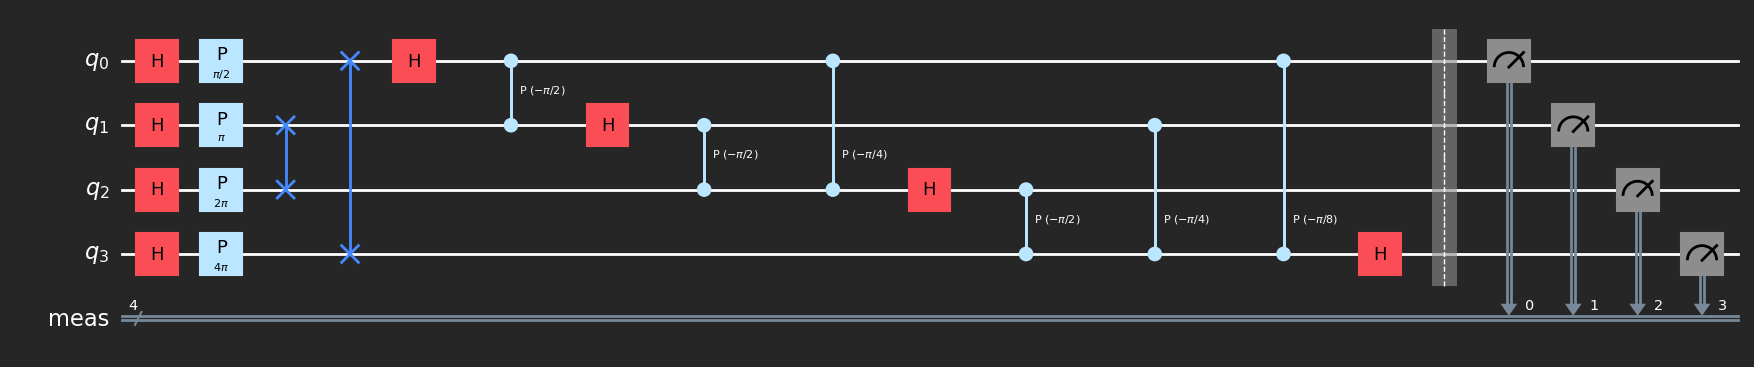

In [154]:
n = 4
initialize = 4
inverse = True
measurement = True

qft_qc = qft(n, [initialize, inverse, measurement])

decomposer(qft_qc, 0).draw(style="iqp-dark") #iqp, iqp-dark, textbook, bw, clifford

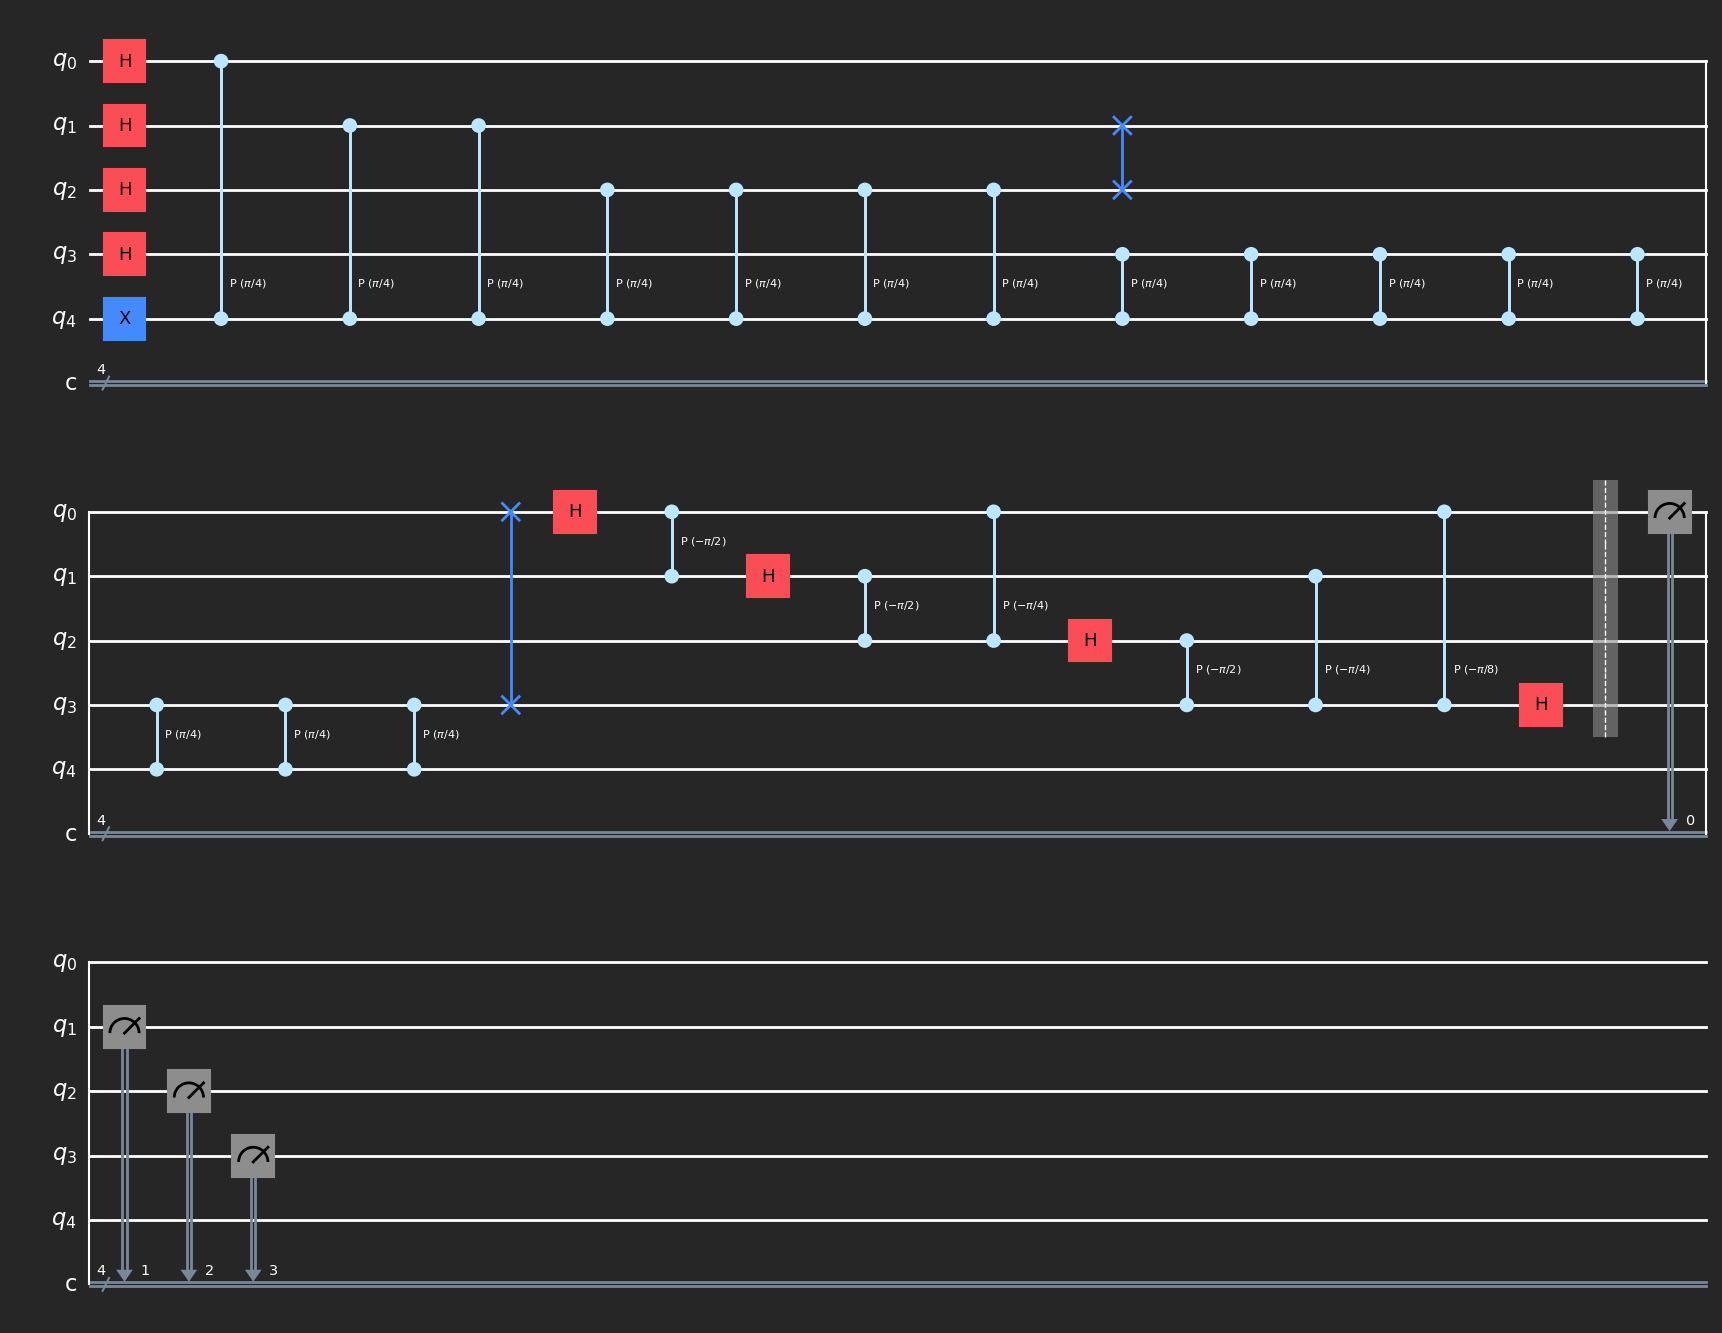

In [155]:
n = 4
phase_theta = 1/8

qpe_qc = qpe(n, [phase_theta])

decomposer(qpe_qc, 0).draw(style="iqp-dark") #iqp, iqp-dark, textbook, bw, clifford

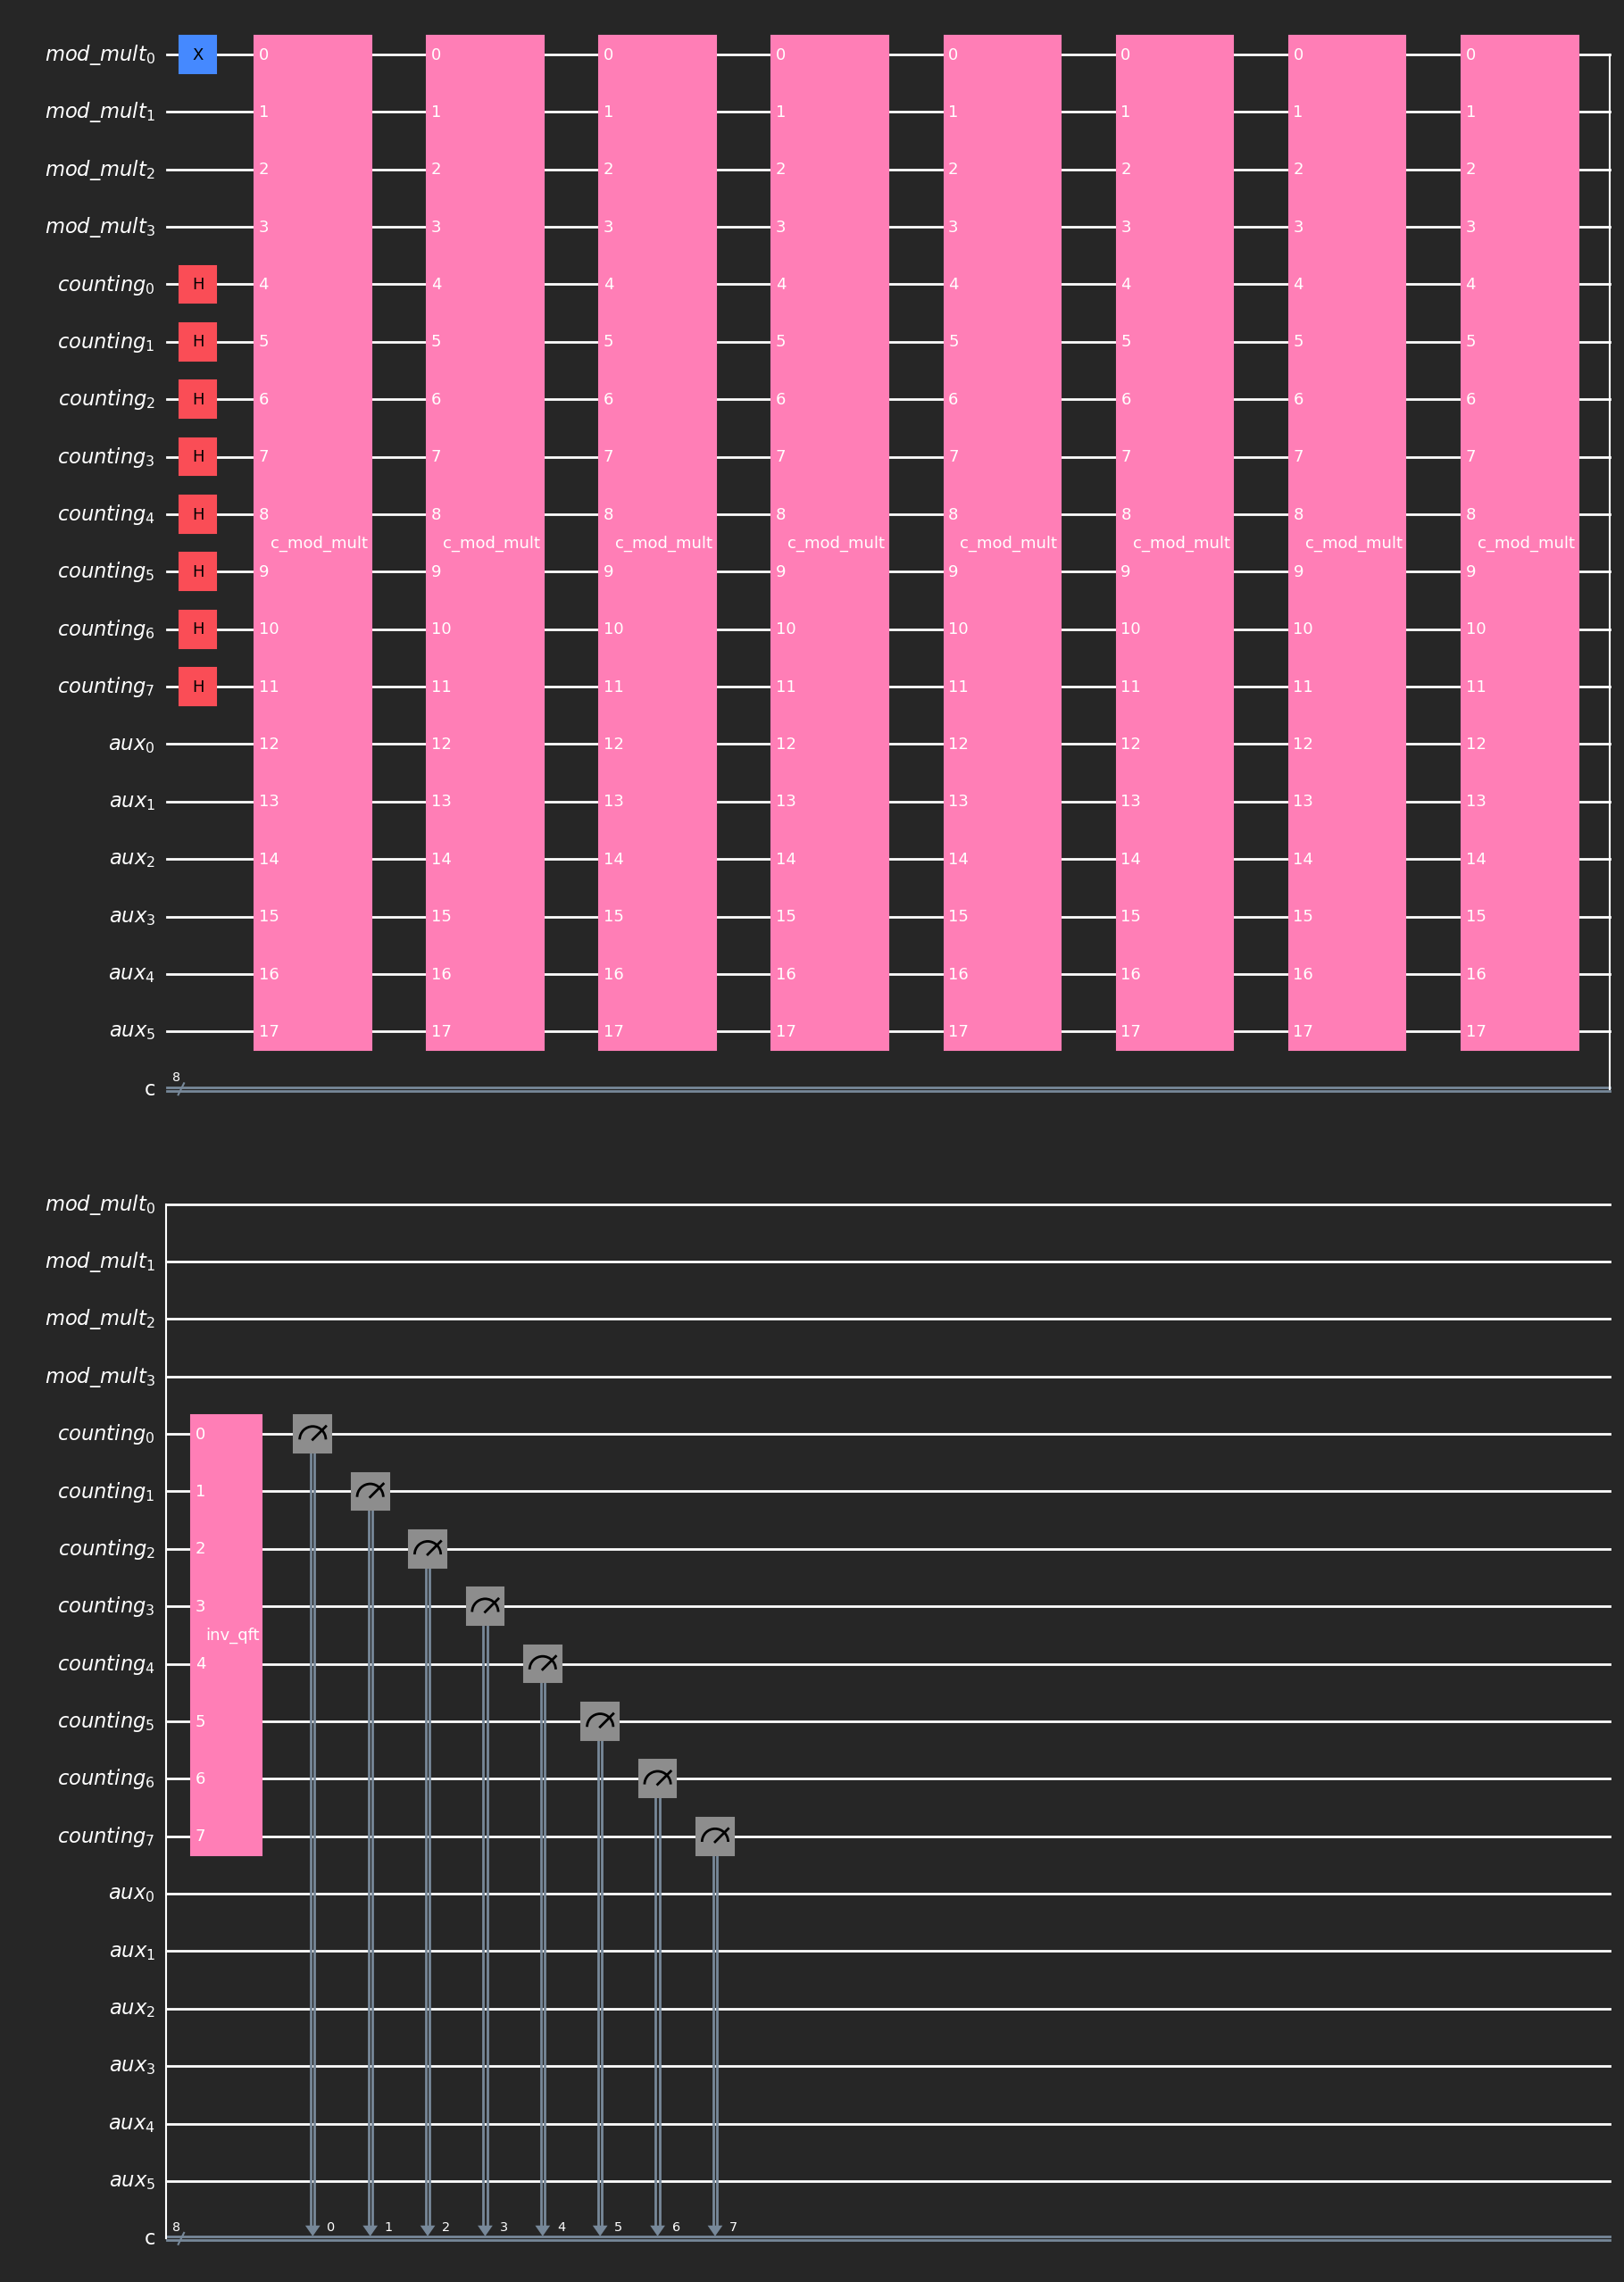

In [156]:
N = 15 #[15, 21, 35, 39, 51, 55, 57, 65, 69, 77, 85, 87, 91, 93, 95, 105, 111, 115, 119, 123]
random = True

shor_qc = shor(N, [random])

decomposer(shor_qc, 0).draw(style="iqp-dark") #iqp, iqp-dark, textbook, bw, clifford

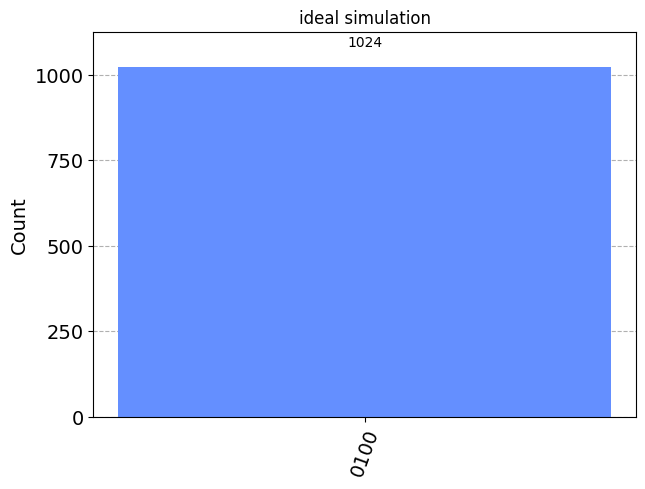

CPU times: user 118 ms, sys: 60.1 ms, total: 178 ms
Wall time: 104 ms


In [157]:
%%time

qc = qft_qc
shots = 1024
optimization_level = 0
seed = None
show_plot = True
show_counts = False

sorted_counts, raw_counts = run_ideal_simulation(qc, shots, optimization_level, seed, show_plot, show_counts)